In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiLineString
from shapely.ops import substring, nearest_points
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False

# 加载矢量数据
river_gdf = gpd.read_file('../data/最新赣江河流.shp')
intersection_gdf = gpd.read_file('../data/河流交汇点.shp')
duanmian_gdf = gpd.read_file('../data/赣江流域断面点.shp')


# 打印矢量数据的坐标系
print("河流坐标系 CRS:", river_gdf.crs)
print("河流交汇点坐标系 CRS:", intersection_gdf.crs)
print("断面点坐标系 CRS:", duanmian_gdf.crs)


河流坐标系 CRS: EPSG:4326
河流交汇点坐标系 CRS: EPSG:4326
断面点坐标系 CRS: EPSG:4326


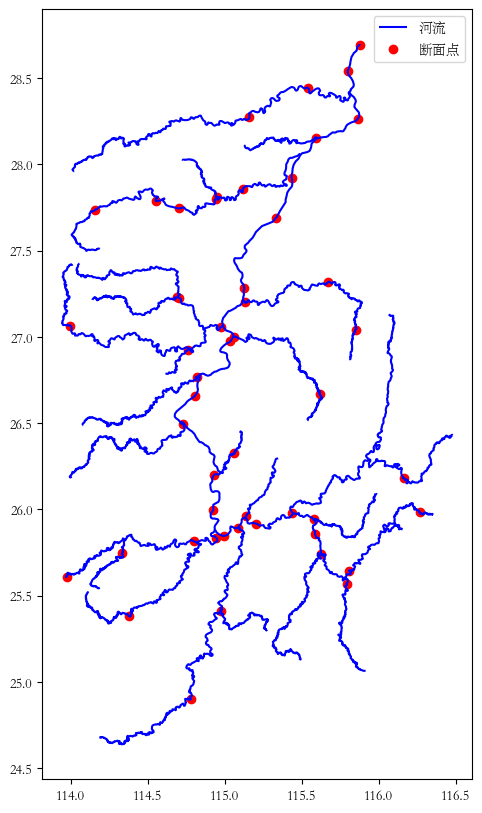

In [6]:
# 可视化检查断面点和河流数据
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
river_gdf.plot(ax=ax, color='blue', label='河流')
duanmian_gdf.plot(ax=ax, color='red', marker='o', label='断面点')
plt.legend()
plt.show()


In [7]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

def create_candidate_points(line, distance, existing_points):
    # 计算河流的总长度
    total_length = line.length
    # 初始化候选点列表
    candidate_points = []
    # 从终点往起点每隔一定距离创建候选点
    current_distance = 0
    while current_distance <= total_length:
        point = line.interpolate(total_length - current_distance)
        # 使用圆度来避免浮点数精度问题
        point_rounded = (round(point.x, 6), round(point.y, 6))
        if point_rounded not in existing_points:
            candidate_points.append(point)
            existing_points.add(point_rounded)
        current_distance += distance
    return candidate_points

# 设置每隔的距离（米）
distance_interval = 10000  # 例如，每隔10km创建一个候选点

# 将坐标系转换为适合测量的投影坐标系（例如，UTM Zone 50N）
river_gdf = river_gdf.to_crs(epsg=32650)

# 初始化所有候选点的列表和已存在的点集合
all_candidate_points = []
existing_points = set()

# 遍历每条河流
for river in river_gdf.geometry:
    if isinstance(river, LineString):
        candidate_points = create_candidate_points(river, distance_interval, existing_points)
        all_candidate_points.extend(candidate_points)
    elif isinstance(river, MultiLineString):
        # 使用 .geoms 来获取 MultiLineString 内的 LineString 几何
        for sub_line in river.geoms:
            candidate_points = create_candidate_points(sub_line, distance_interval, existing_points)
            all_candidate_points.extend(candidate_points)

# 创建GeoDataFrame来存储候选点，并转换回原始坐标系
candidate_points_gdf = gpd.GeoDataFrame(geometry=all_candidate_points, crs=river_gdf.crs)
candidate_points_gdf = candidate_points_gdf.to_crs(epsg=4326)

# 为GeoDataFrame添加唯一标识符列，point_id 从 52 开始
start_id = 52
candidate_points_gdf['point_id'] = range(start_id, start_id + len(candidate_points_gdf))

# 保存到新的shapefile
# candidate_points_gdf.to_file('../候选点.shp')

# 候选点个数
print("候选点个数:", len(candidate_points_gdf))

# 打印转换回原始CRS后的CRS
print("候选点 CRS:", candidate_points_gdf.crs)

# 打印前几行以查看结果
print(candidate_points_gdf.head())


候选点个数: 442
候选点 CRS: EPSG:4326
                               geometry  point_id
0  POINT Z (115.08341 25.89297 0.00000)        52
1  POINT Z (115.11914 25.84769 0.00000)        53
2  POINT Z (115.09497 25.78509 0.00000)        54
3  POINT Z (115.09340 25.71766 0.00000)        55
4  POINT Z (115.04544 25.66689 0.00000)        56


In [8]:
import geopandas as gpd
import pandas as pd

retain_points_gdf = gpd.read_file('../保留的赣江断面.shp')
# candidate_points_gdf = gpd.read_file('../候选点.shp')

# 合并投影后的保留点和候选点的GeoDataFrame
combined_points_gdf = pd.concat([retain_points_gdf, candidate_points_gdf], ignore_index=True)

# 为合并后的GeoDataFrame添加FID属性值
combined_points_gdf['FID'] = range(1, len(combined_points_gdf) + 1)

# 保存合并后的GeoDataFrame为新的shapefile
combined_points_gdf.to_file('../候选点(保留的赣江断面).shp', encoding='utf-8')

print("合并完成，已保存为新的shapefile，并添加了FID属性。")


合并完成，已保存为新的shapefile，并添加了FID属性。
